In [7]:
import numpy as np
import matplotlib.pyplot as plt

Punto 1:

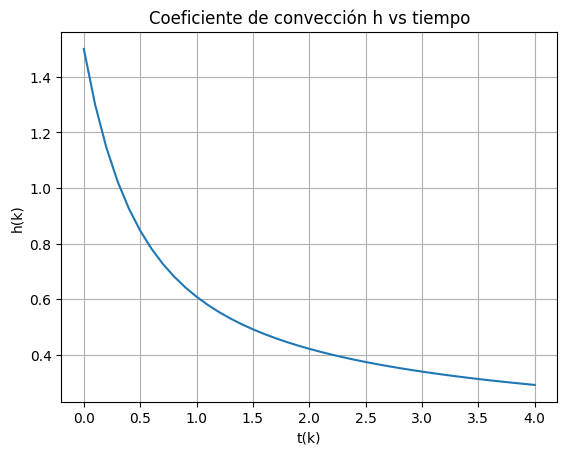

In [15]:
# Parámetros
dy = 1
dt = 0.1
alpha = 1
kf = alpha
N = 40
K = 40

# Mallado
y = np.arange(0, N+1) * dy
t = np.arange(0, K+1) * dt

# Matriz de temperaturas
T = np.zeros((K+1, N+1))

# Condición inicial
T[0,0] = 1
T[0,1:] = 0

# Iteración temporal usando ecuación (3)
for k in range(1, K+1):
    for n in range(1, N):   # n=1..N-1
        T[k,n] = T[k-1,n] + alpha * dt / dy**2 * (T[k-1,n-1] + T[k-1,n+1] - 2*T[k-1,n])
    T[k,0] = 1   # placa caliente
    T[k,N] = 0   # extremo lejano frío

# Calcular derivada ∂T/∂y|0
dTdy = np.zeros(K+1)
for k in range(K+1):
    dTdy[k] = (-3/2*T[k,0] + 2*T[k,1] - 1/2*T[k,2]) / dy

# Cálculo de h(k)
Tp = 1
Tinf = 0
kf = alpha  # dado
h = (-kf * dTdy) / (Tp - Tinf)

# Graficar h vs k
plt.plot(t, h)
plt.xlabel("t(k)")
plt.ylabel("h(k)")
plt.title("Coeficiente de convección h vs tiempo")
plt.grid(True)
plt.show()


Punto 2:

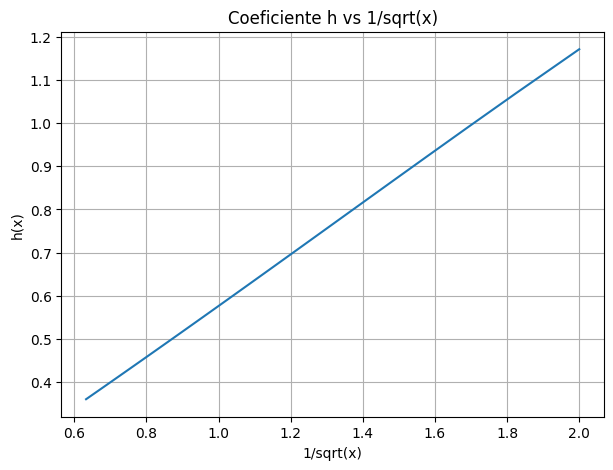

In [34]:
# ---------------------------------------------------
# Parámetros físicos y numéricos
# ---------------------------------------------------
dy = 0.5
dt = 0.05
alpha = 1.0
Uinf = 1.0
dx = Uinf * dt

Tp = 1.0
Tinf = 0.0
kf = alpha

# Mallado
N = 40   # puntos en y
I = 50   # puntos en x
K = 50  # pasos de tiempo

# T[k,i,n] = tiempo k, posición x->i, y->n
T = np.zeros((K+1, I+1, N+1))

# ---------------------------------------------------
# CONDICIONES INICIALES 
# ---------------------------------------------------
# Fluido frío en todo el dominio
T[0,:,:] = Tinf

# Fluido en contacto con la pared caliente en y=0
T[0,:,0] = Tp

# ---------------------------------------------------
# BUCLE PRINCIPAL
# ---------------------------------------------------
for k in range(1, K+1):
    # ======== 1. DIFUSIÓN (conducción en y) ========
    T_cond = np.copy(T[k-1])  # copia de la capa anterior
    for i in range(I+1):
        for n in range(1, N):
            T_cond[i,n] = ( T[k-1,i,n] 
                            + alpha * (dt / dy**2) *
                              ( T[k-1,i,n-1] + T[k-1,i,n+1] - 2*T[k-1,i,n] )
                          )

        # Condiciones de borde en y
        T_cond[i,0] = Tp     # pared caliente
        T_cond[i,N] = Tinf   # temperatura fria del fluido lejos de la pared

    # ======== 2. TRANSPORTE: T(x+dx) = T_cond(x) ========
    # fluido avanza en +x
    for i in range(1, I+1):
        T[k,i,:] = T_cond[i-1,:]

    # condición de entrada en y=0 (fluido frío + pared caliente)
    T[k,:,0] = Tp
    T[k,0,1:] = Tinf

# ---------------------------------------------------
# Calcular dT/dy y coeficiente h
# ---------------------------------------------------
dTdy = np.zeros((K+1, I+1))

for k in range(K+1):
    for i in range(I+1):
        dTdy[k,i] = (-1.5*T[k,i,0] + 2*T[k,i,1] - 0.5*T[k,i,2]) / dy

h = -kf * dTdy / (Tp - Tinf)

# Posiciones
x = np.arange(0, I+1) * dx
inv_sqrt_x = np.zeros_like(x)
inv_sqrt_x[1:] = 1/np.sqrt(x[1:])

# ---------------------------------------------------
# Gráfica final
# ---------------------------------------------------
plt.figure(figsize=(7,5))
plt.plot(inv_sqrt_x[5:], h[K,5:])
plt.xlabel('1/sqrt(x)')
plt.ylabel('h(x)')
plt.grid(True)
plt.title('Coeficiente h vs 1/sqrt(x)')
plt.show()
